In [6]:
from uuid import UUID
from vitalx.types import VitalEnvironmentT
from vitalx.types import VitalRegionT

environment: VitalEnvironmentT = "sandbox"
region: VitalRegionT = "us"

team_id = UUID("TEAM_ID")
user_id = UUID("USER_ID")

In [9]:
from vitalx.aggregation.executor import Executor

executor = Executor(
    environment=environment,
    region=region,
    team_id=team_id,
)


## Aggregation Query

In [13]:
from datetime import date
from vitalx.aggregation import Period, RelativeTimeframe
from vitalx.aggregation.dsl import Sleep, date_part, date_trunc, group_key, select

(sleep_score_by_day,) = executor.query(
    RelativeTimeframe(
        type="relative",
        anchor=date.today(),
        past=Period(value=3, unit="month"),
    ),
    select(
        group_key("*"),
        Sleep.score().newest(),
    ).group_by(date_trunc(Sleep.index(), 1, "day")),

    user_id=user_id,
)


## Sleep Scores

In [14]:
sleep_score_by_day

group_key.0,newest
datetime[μs],i64
2024-08-07 00:00:00,79
2024-08-08 00:00:00,77
2024-08-09 00:00:00,77
2024-08-10 00:00:00,75
2024-08-11 00:00:00,81
…,…
2024-11-03 00:00:00,71
2024-11-04 00:00:00,82
2024-11-05 00:00:00,74


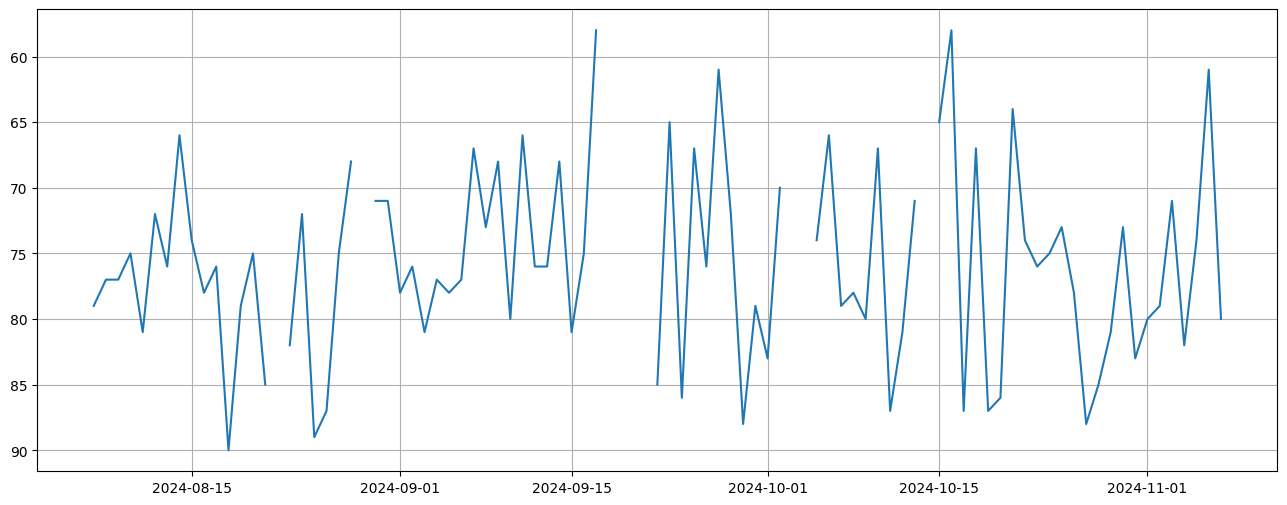

In [17]:
from datetime import datetime, date, time, timedelta
from typing import cast
import matplotlib.pyplot as plt


plt.figure(figsize=(16,6))
ax = plt.gca()
ax.yaxis.set_inverted(True)
plt.grid()
plt.plot(
    sleep_score_by_day.get_column("group_key.0"),
    sleep_score_by_day.get_column("newest"),
)
plt.show()